Lab1-1-BRATS-3D-fastMONAI-extended | A. Lundervold & A.S. Lundervold | v2023-12-31

# Brain tumor 3D segmentation with fastMONAI

This notebook is essentially a cell-by-cell commented copy of the **multi-class semantic segmentation** notebook `10d_tutorial_multiclass_segmentation.ipynb` from [fastMONAI](https://github.com/MMIV-ML/fastMONAI), and also incoporating parts of the extended notebook in https://github.com/MMIV-ML/fastMONAI/tree/master/presentations/MMIV-1022. We will not have time for a detailed introduction to MONAI. Please consult the documentation: https://monai.io and also see their [tutorials](https://github.com/Project-MONAI/tutorials).

| Notebook    |      1-Click Notebook      |
|:----------|------|
|  [Lab1-1-BRATS-3D-fastMONAI-extended.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/ELMED219/blob/main/Lab1-mpMRI-glioma/Lab1-1-BRATS-3D-fastMONAI-extended.ipynb)<br> The present notebook   | [![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219/blob/main/Lab1-mpMRI-glioma/Lab1-1-BRATS-3D-fastMONAI-extended.ipynb)|
|  [10d_tutorial_multiclass_segmentation.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/fastMONAI/blob/main/nbs/10d_tutorial_multiclass_segmentation.ipynb)<br> fastMONAI tutoral on multi-class semantic segmentation   | [![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10d_tutorial_multiclass_segmentation.ipynb)|
|  [MMIV-Oct2022-brain_tumor_segmentation.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/fastMONAI/blob//blob/master/presentations/MMIV-1022/MMIV-Oct2022-brain_tumor_segmentation.ipynb)<br> fastMONAI demo (A.S.L.) at the MMIV Seminar, October 21, 2022 | [![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/presentations/MMIV-1022/MMIV-Oct2022-brain_tumor_segmentation.ipynb)|

The tutorial notebook shows how to construct a training workflow of a **multi-labels segmentation task**:<br>

_Obtain pre-defined biologically/clinically significant subregions of a brain tumor from multiparametric 3D MRI recordings using supervised learning with 3D convolutional deep neural networks_, i.e.

##  Multilabel tumor segmentation:  $y  \approx f(X; \theta)$

### Data $X$:

In our case we are using multiparametric magnetic resonance images ([mp-MRI](https://en.wikipedia.org/wiki/MRI_sequence)) recordings from previous BraTS challenges openly available in the **Medical Segmentation Decathlon** ([MSD](https://arxiv.org/abs/2106.05735)) repository (http://medicaldecathlon.com) as `Task01_BrainTumor.tar` (see also https://decathlon-10.grand-challenge.org).

The data set consists of 750 mp-MRI recordings from patients diagnosed with either glioblastoma or lower-grade glioma (LGG). The sequences used were native
T1-weighted (T1), post-Gadolinium (Gd) contrast T1-weighted (T1-Gd), native T2-weighted (T2),
and T2 Fluid-Attenuated Inversion Recovery (FLAIR). The corresponding target ROIs were the
three tumor sub-regions, namely edema, enhancing, and non-enhancing tumor. This data set was
selected due to the challenge of locating these complex and heterogeneously-located targets. The
data was acquired from 19 different institutions and contained a subset of the data used in the
[2016](https://www.smir.ch/BRATS/Start2016) and [here](https://paperswithcode.com/dataset/brats-2016) and [2017](https://www.med.upenn.edu/sbia/brats2017.html) Brain Tumor Segmentation (BraTS) challenges [12, 13, 14].

There are a total of 750 4D volumes available, 484 four-channel MRI images (`imagesTr` folder) with corresponding multi-label images (`labelsTr`) available for training, and 266 mpMRI recordings (no corresponding labels provided) in the `ìmagesTs`folder. The provided data are distributed after their pre-processing, i.e. co-registered to the same anatomical template, interpolated to the same resolution (1 mm$^3$) and skull-stripped. 


### Labels and classes $y$:

In this challenge we have the following **labels** for the data:
  - label 0 is non-tumor
  - label 1 is the peritumoral edema
  - label 2 is the necrotic and non-enhancing tumor core
  - label 3 is the GD-enhancing tumor

The possible **classes** are:
  - TC (Tumor core)
  - WT (Whole tumor)
  - ET (Enhancing tumor)

(merging label 2 and label 3 to construct TC, merging labels 1, 2 and 3 to construct WT, and label 3 is ET)

![img](./assets/ELMED219-Lab1-BraTS-data.png)

### Model $f$ and trainable parameters $\theta$:

In our $y  \approx f(X; \theta)$ notation we will for each voxel location $v \in \Omega(X)$ (spatial domain of the multiparametric brain image $X$) have


- $y_v \in \{y_1, y_2, y_3, y_4\}$ = {_TC_, _WT_, _ET_, non-tumor} (these regions are illustrated in the figure below)


- $f$ is a 3D convolutional deep neural net model (i.e. `SegResNet`), and 


- $\theta = (\theta_1, \theta_2, ...., \theta_p)$ is the $p$ trainable model parameters (``synaptic weights") in $f$ (in our `SegResNet` model $p \sim 4.7 \cdot 10^6$), and


- $\approx$ denotes _approximation_ expressed by a loss function or performance metric such as the Dice coefficient for the segmentation, e.g. accross one epoch during training: 


And it contains the following steps:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](./assets/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).



### Note on BraTS 2021

- **[NVIDIA Data Scientists](https://developer.nvidia.com/blog/nvidia-data-scientists-take-top-spots-in-miccai-2021-brain-tumor-segmentation-challenge) Take Top Spots in MICCAI 2021 [Brain Tumor Segmentation Challenge](http://www.braintumorsegmentation.org)**:


 - Optimized U-Net for Brain Tumor Segmentation – Rank #1 (based on [`nnU-Net`](https://github.com/MIC-DKFZ/nnUNet) winner of [BraTS 2020](https://www.med.upenn.edu/cbica/brats2020) by [Isense et al.](https://arxiv.org/abs/2011.00848))
  
  
 - SegResNet: Redundancy Reduction in Semantic Segmentation of 3D Brain MRIs – Rank #2<br> The main model is the SegResNet architecture from MONAI, a standard encoder-decoder based convolutional neural network (CNN) similar to U-Net. 
  
![SegResNet](https://developer-blogs.nvidia.com/wp-content/uploads/2021/09/BRaTS-fig-2.png)
  
_A typical segmentation example with predicted labels overlaid overT1c MRI axial, sagittal and coronal slices. The whole tumor (WT) class includes all visible labels (a union of green, yellow and red labels), the tumor core (TC) class is a union of red and yellow, and the enhancing tumor core (ET) class is shown in yellow
(a hyperactive tumor part)._


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brain-tumor-segmentation-using-fastMONAI" data-toc-modified-id="Brain-tumor-segmentation-using-fastMONAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brain tumor segmentation using <code>fastMONAI</code></a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-and-inspect-the-data" data-toc-modified-id="Load-and-inspect-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load and inspect the data</a></span><ul class="toc-item"><li><span><a href="#Inspect-the-data" data-toc-modified-id="Inspect-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Inspect the data</a></span></li><li><span><a href="#Data-augmentation-and-dataloaders" data-toc-modified-id="Data-augmentation-and-dataloaders-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation and dataloaders</a></span><ul class="toc-item"><li><span><a href="#What-is-data-augmentation?" data-toc-modified-id="What-is-data-augmentation?-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>What is data augmentation?</a></span></li><li><span><a href="#Create-dataloaders" data-toc-modified-id="Create-dataloaders-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Create dataloaders</a></span></li></ul></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Loss-function" data-toc-modified-id="Loss-function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loss function</a></span></li></ul></li><li><span><a href="#Evaluate-results" data-toc-modified-id="Evaluate-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate results</a></span><ul class="toc-item"><li><span><a href="#Inference-on-test-data" data-toc-modified-id="Inference-on-test-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Inference on test data</a></span></li></ul></li><li><span><a href="#Export-the-model-and-dataloader" data-toc-modified-id="Export-the-model-and-dataloader-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Export the model and dataloader</a></span></li><li><span><a href="#Extra:-Radiomics" data-toc-modified-id="Extra:-Radiomics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Extra: Radiomics</a></span></li></ul></div>

# Brain tumor segmentation using `fastMONAI`

This notebook illustrates an approach to constructing a brain tumor segmentation model based on MR images. We aim to extract meaningful tumor regions directly from multimodal MRI (T1w, T1ce, T2w, and FLAIR). In this case, the active tumor (AT), necrotic core (NCR), and peritumoral edematous/infiltrated tissue (ED).

<img width=40% src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/brain_tumor.jpeg">

Here's an illustration of what we want to achieve (illustration taken from the BraTS Challenge):

<img src="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg">

# Setup

We must first set up the software libraries we'll use to construct our model. Chief among these is the `fastMONAI` library.

<a href="https://fastmonai.no"><img src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/fastmonai_no.png"></a>

### Check your platform

In [61]:
import platform
import os
from os.path import expanduser
home = expanduser("~")

if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    MacOS = True
    Linux = False
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/bin/tree -L 4'
    Linux = True
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')
    MacOS = False
    Linux = False

OK, you are running on Linux (#40~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 16 10:53:04 UTC 2)


This code in the cell checks the operating system on which the code is running and sets up some variables accordingly. Here's a breakdown of the code:

- The `platform` module is imported to access information about the operating system.
- The `os` module is imported to interact with the operating system.
- The `expanduser` function from `os.path` is imported to expand the `~` symbol in file paths to the user's home directory.

The code then checks the operating system using `platform.system()` and performs different actions based on the result:

- If the operating system is identified as 'Darwin', which corresponds to macOS, the code prints a message indicating that the code is running on macOS and sets the `OVERLEAF_dir` variable to a specific path on the user's Dropbox. It also sets the `TREE` variable to the command for displaying a directory tree structure on macOS.
- If the operating system is identified as 'Linux', the code prints a message indicating that the code is running on Linux and sets the `OVERLEAF_dir` variable to a specific path on the user's Dropbox. It also sets the `TREE` variable to the command for displaying a directory tree structure on Linux.
- If the operating system is identified as 'Windows', the code prints a message suggesting the installation of Windows Subsystem for Linux (WSL) for better compatibility. It also sets the `MacOS` and `Linux` variables to `False`.

The purpose of this code is to set up specific configurations or paths based on the operating system on which the code is running. It provides different paths and commands for macOS, Linux, and Windows operating systems, allowing for platform-specific behavior or settings.

### Check if Colab and GPU is available

In [62]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()

except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")
    #%pip install fastMONAI # (8m 23 s on MacOS; 7 m 51 s on Ubuntu 20.04)
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()


Not running in Google Colab.
GPU attached.


This code snippet checks whether the notebook is running in a Google Colaboratory environment or not. Here's a breakdown of the code:

- The code starts with a `try-except` block. It attempts to import the `google.colab` module, which is specific to Google Colaboratory. If the import is successful, it means that the code is running in a Colab environment, and the `is_colab` variable is set to `True`.

- If the import fails and raises an `ImportError`, it means that the code is not running in a Colab environment, and the `is_colab` variable is set to `False`.

- Depending on whether the code is running in Colab or not, it prints a corresponding message indicating the environment.

- If the code is running in Colab, it installs the `fastMONAI` library using `%pip install fastMONAI`. The `%pip` syntax is specific to Colab and is used to install Python packages directly from the notebook.

- It then imports the `print_colab_gpu_info` function from `fastMONAI.utils` and calls it to print information about the GPU available in the Colab environment.

- If the code is not running in Colab, it skips the installation step and directly imports the `print_colab_gpu_info` function from `fastMONAI.utils`. It then calls the function to print GPU information, although this information may not be available or relevant outside of Colab.

Overall, this code snippet is checking the environment and performing environment-specific actions, such as installing packages or printing GPU information, based on whether the code is running in Google Colaboratory or not.

In [63]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

In this code excerpt, the following actions are taking place:

- The `fastMONAI.vision_all` module is being imported using the `from ... import *` syntax. This syntax imports all the functions, classes, and variables defined in the `fastMONAI.vision_all` module, making them directly accessible without needing to prefix them with the module name.

- The `monai.apps` module is being imported, specifically the `DecathlonDataset` class. This class is likely part of the MONAI library and is used for loading and working with the Decathlon dataset, which is a collection of medical imaging datasets for various tasks.

- The `sklearn.model_selection` module is being imported, specifically the `train_test_split` function. This function is part of the scikit-learn library and is commonly used for splitting datasets into training and testing subsets.

By importing these modules and classes, the code is preparing to use the functionalities provided by `fastMONAI`, `monai.apps`, and `sklearn.model_selection` in the subsequent code.

### Check our environment and computing resources

In [64]:
from monai.config import print_config
print_config()

MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/arvid/anaconda3/envs/elmed219/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

The code snippet is importing the `print_config` function from the `monai.config` module and then calling the `print_config()` function.

Here's a breakdown of what this code does:

- The `from monai.config import print_config` statement imports the `print_config` function from the `monai.config` module. The `monai.config` module is part of the MONAI library, which is a deep learning library for medical imaging.

- The `print_config()` function is then called. This function is responsible for printing the configuration settings of the MONAI library. It provides information about the current configuration, such as the version of MONAI, the PyTorch version, and other relevant settings.

By executing this code, the configuration details of the MONAI library will be printed to the output. This can be useful for verifying the library version, checking the configuration settings, and ensuring that the MONAI library is properly installed and configured in the current environment.

# Load and inspect the data

> We will use the brain tumors dataset from the Medical Segmentation Decathlon challenge (http://medicaldecathlon.com/). The data is collected from the Multimodal Brain Tumor Image Segmentation Benchmark Challenge (BraTS) dataset from 2016 and 2017. The task is to segment tumors into three different subregions (active tumor (AT), necrotic core (NCR), and peritumoral edematous/infiltrated tissue (ED)) from multimodal multisite MRI data (T1w, T1ce, T2w, and FLAIR). 

In [65]:
if is_colab:
   ! wget https://raw.githubusercontent.com/MMIV-ML/ELMED219/main/Lab1-mpMRI-glioma/assets/brats-montage.png
   image = Image.open("brats-montage.png") # Load the image.
   rotated_image = image.rotate(180) # Rotate the image by 180 degrees.
   rotated_image.save("brats-montage-rot180.png") # Save the rotated im
   !ls *.png
else:
   from PIL import Image # Import Image class from the library.
   image = Image.open("./assets/brats-montage.png") # Load the image.
   rotated_image = image.rotate(180) # Rotate the image by 180 degrees.
   rotated_image.save("./assets/brats-montage-rot180.png") # Save the rotated im

This code snippet checks whether the notebook is running in a Google Colaboratory environment or not. Here's a breakdown of the code:

- The code starts with an `if` statement that checks the value of the `is_colab` variable. If it evaluates to `True`, it means that the code is running in a Colab environment.

- Inside the `if` block, the code uses the `!` syntax to execute shell commands directly in the Colab environment. It first uses `wget` to download an image file named "brats-montage.png" from a specific URL. 

- The `Image.open()` function from the `PIL` (Python Imaging Library) module is then used to open the downloaded image file.

- The `rotate()` method is called on the `image` object to rotate the image by 180 degrees.

- The `save()` method is used to save the rotated image as "brats-montage-rot180.png".

- The `!ls *.png` command is executed to list all the PNG files in the current directory.

- If the `is_colab` variable evaluates to `False`, indicating that the code is not running in a Colab environment, the code imports the `Image` class from the `PIL` module.

- The `Image.open()` function is then used to open the image file located at "./assets/brats-montage.png".

- The `rotate()` method is called on the `image` object to rotate the image by 180 degrees.

- The `save()` method is used to save the rotated image as "./assets/brats-montage-rot180.png".

Overall, this code snippet downloads an image file, opens it, rotates it by 180 degrees, and saves the rotated image. The specific file paths and commands used depend on whether the code is running in a Colab environment or not.

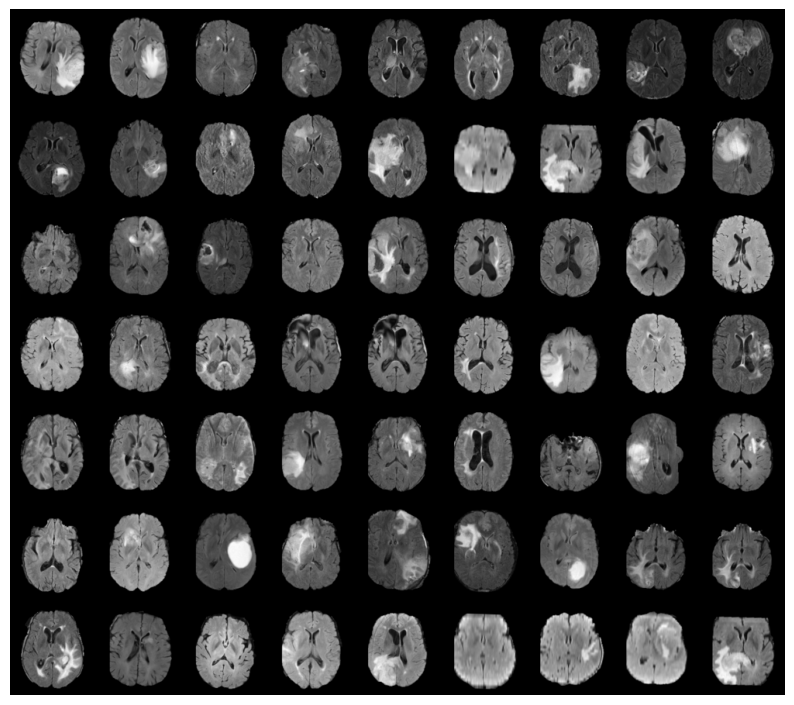

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if is_colab:
    img = mpimg.imread('brats-montage-rot180.png')
else:
    img = mpimg.imread('./assets/brats-montage-rot180.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

# Alternatively, you can use the IPython.display.Image class to display the image directly in the notebook.
# from IPython.display import Image
# Image(filename="./assets/brats-montage-rot180.png")


This code snippet is responsible for displaying an image in the notebook using the `matplotlib` library. Here's a breakdown of the code:

- The `matplotlib.pyplot` and `matplotlib.image` modules are imported as `plt` and `mpimg`, respectively.

- The code checks the value of the `is_colab` variable. If it evaluates to `True`, indicating that the code is running in a Google Colaboratory environment, it reads the image file "brats-montage-rot180.png" using `mpimg.imread()`.

- If the `is_colab` variable evaluates to `False`, indicating that the code is not running in a Colab environment, it reads the image file "./assets/brats-montage-rot180.png" using `mpimg.imread()`.

- The `plt.figure()` function is called to create a new figure with a specified size of 10x10 inches.

- The `plt.imshow()` function is used to display the image stored in the `img` variable.

- The `plt.axis('off')` function is called to remove the axis labels and ticks from the plot.

- Finally, the `plt.show()` function is called to display the image in the notebook.

- There is also a commented-out alternative approach using the `IPython.display.Image` class to directly display the image in the notebook. This approach is not used in the current code.

Overall, this code snippet reads an image file, displays it using `matplotlib.pyplot`, and shows the image in the notebook. The specific file paths and commands used depend on whether the code is running in a Colab environment or not.

We use the MONAI function `DecathlonDataset` to download the data and generate items for training.
<!--
<img src="./assets/brats-montage-rot180.png">
-->

In [67]:
from pathlib import Path

path = Path('./data')
path.mkdir(exist_ok=True)

In the first line, the `pathlib` module is imported, which provides a convenient way to work with file paths and directories.

In the second line, a `Path` object is created with the path `./data`. The `Path` class represents a file or directory path and provides various methods for working with paths.

In the third line, the `mkdir()` method is called on the `path` object. This method creates a new directory at the specified path. The `exist_ok=True` parameter ensures that the directory is created only if it doesn't already exist. If the directory already exists, it will not raise an error.

By executing this code, a directory named "data" will be created in the current working directory if it doesn't already exist. This directory can be used to store data or files related to the code or project.

Grab the data (if not already fetched)
7.09 G [Colab: 03:20, 38.2 MB/s] [./data/Task01_BrainTumour.tar]

In [68]:
training_data = DecathlonDataset(root_dir=path, task="Task01_BrainTumour", section="training", download=True,
                                 cache_num=0, num_workers=8)

2023-12-31 12:41:54,968 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-12-31 12:41:54,969 - INFO - File exists: data/Task01_BrainTumour.tar, skipped downloading.
2023-12-31 12:41:54,970 - INFO - Non-empty folder exists in data/Task01_BrainTumour, skipped extracting.


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


The code initializes a `DecathlonDataset` object named `training_data` with various parameters:

- `root_dir=path`: This parameter specifies the root directory where the dataset is located. The value of `path` is a file path pointing to the dataset directory.

- `task="Task01_BrainTumour"`: This parameter specifies the specific task or dataset within the Decathlon dataset. In this case, it is the "Task01_BrainTumour" task, which likely corresponds to brain tumor segmentation.

- `section="training"`: This parameter specifies the section or subset of the dataset to be loaded. In this case, it is the training section, indicating that the training data will be loaded.

- `download=True`: This parameter indicates whether the dataset should be downloaded if it is not already available. Setting it to `True` will trigger the download process if necessary.

- `cache_num=0`: This parameter specifies the cache number to be used. The value `0` suggests that no caching is performed.

- `num_workers=8`: A worker process refers to an independent process that performs a specific task or job in parallel with other processes. In the context of data loading, a worker process is responsible for loading and preprocessing data independently from other worker processes. When loading large datasets or performing computationally intensive tasks, using multiple worker processes can help distribute the workload and speed up the overall process. Each worker process operates independently and can handle a portion of the data loading task concurrently. In this case, the `num_workers` parameter specifies the number of worker processes to be used for loading the data. By setting it to `8`, it indicates that eight worker processes will be utilized to load the data in parallel. This parallelization can lead to faster data loading and preprocessing, especially when dealing with large datasets.

By executing this code, a `DecathlonDataset` object named `training_data` will be created, representing the training data for the brain tumor segmentation task. The dataset will be loaded from the specified root directory, and if necessary, it will be downloaded. The data loading process will utilize eight worker processes for efficient parallel loading.

In [70]:
df = pd.DataFrame(training_data.data)

The code snippet creates a pandas DataFrame named `df` by passing the `training_data.data` attribute as the data argument.

Here's a breakdown of the code:

- `training_data` is an object representing a dataset, loaded from the `DecathlonDataset` class mentioned earlier.
- `training_data.data` refers to the data portion of the loaded dataset, which contain features, labels, or other relevant information.

By calling `pd.DataFrame()` with `training_data.data` as the argument, the code converts the data into a pandas DataFrame. A DataFrame is a two-dimensional tabular data structure provided by the pandas library, commonly used for data manipulation and analysis.

The resulting DataFrame, `df`, will have the data from `training_data.data` organized in rows and columns. Each row represents an individual data point, and each column represents a specific attribute or feature of the data.

This code allows for further analysis, exploration, or manipulation of the dataset using the rich functionality provided by pandas for working with tabular data.

We now have a bunch of **images** and **corresponding labels**. Here are the first ten images and their labels:

In [71]:
df.head(10)

,image,label
0,data/Task01_BrainTumour/imagesTr/BRATS_442.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_442.nii.gz
1,data/Task01_BrainTumour/imagesTr/BRATS_389.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_389.nii.gz
2,data/Task01_BrainTumour/imagesTr/BRATS_380.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz
3,data/Task01_BrainTumour/imagesTr/BRATS_245.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_245.nii.gz
4,data/Task01_BrainTumour/imagesTr/BRATS_453.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_453.nii.gz
5,data/Task01_BrainTumour/imagesTr/BRATS_252.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_252.nii.gz
6,data/Task01_BrainTumour/imagesTr/BRATS_078.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_078.nii.gz
7,data/Task01_BrainTumour/imagesTr/BRATS_427.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_427.nii.gz
8,data/Task01_BrainTumour/imagesTr/BRATS_421.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_421.nii.gz
9,data/Task01_BrainTumour/imagesTr/BRATS_440.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_440.nii.gz


In [14]:
df.shape

(388, 2)

The code `df.shape` is used to retrieve the shape of the DataFrame `df`. 

Here's a breakdown of the code:

- `df` refers to a pandas DataFrame object that has been previously defined or loaded with data.
- The `.shape` attribute of a DataFrame returns a tuple representing the dimensions of the DataFrame. The tuple contains two values: the number of rows (=388 _instances_, or _data points_, or _records_) and the number of columns (=2 _attributes_, or _features_ -> image and label) in the DataFrame.

By executing `df.shape`, the code will return the shape of the DataFrame `df` as a tuple. This can be useful for understanding the size and structure of the DataFrame, such as the number of data points or records and the number of attributes or features present in the DataFrame.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   388 non-null    object
 1   label   388 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


The code `df.info()` is used to display a summary of the DataFrame `df` including information about the column names, data types, and the number of non-null values in each column.

Here's a breakdown of the code:

- `df` refers to a pandas DataFrame object that has been previously defined or loaded with data.
- The `.info()` method of a DataFrame provides a concise summary of the DataFrame's structure and content.

By executing `df.info()`, the code will display information about the DataFrame `df`. This includes the total number of rows, the number of columns, the column names, the data types of each column, and the number of non-null values in each column. This summary can be helpful for understanding the data types and missing values in the DataFrame, as well as getting an overview of the data present in each column.

#### Each of the 388 data sets consists of four 3D volumes (T1, T1c, T2, FLAIR) and corresponding manual labels. Here's one example:<br><br>


| <img src="./assets/img_182_axial.gif"> | <img src="./assets/img_182_coronal.gif"> | <img src="./assets/img_182_sagittal.gif"> |
|----------|----------|----------|
| Axial         |   Coronal        |    Sagittal       |


We will train our model on parts of the data set, the so-called **training data**. After training, we'll need some new data to test our model's ability to generalize to unseen data, so-called **test data**. 

This is achieved by splitting the labeled data into two sets: training and test.

In [16]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((349, 2), (39, 2))

In [17]:
list(train_df.columns), list(test_df.columns)

(['image', 'label'], ['image', 'label'])

## Inspect the data

`fastMONAI` has a useful function to construct a dataset from a list of labeled images:

In [18]:
#help(MedDataset)

`MedDataset` is a class to extract and present useful information about your dataset.

In [19]:
!nproc  # !grep -c processor /proc/cpuinfo  or more extensive infomation:  !lscpu

16


In [21]:
%%time
#med_dataset = MedDataset(img_list=train_df.label.tolist()[:20], dtype=MedMask, max_workers=12)
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=14)

CPU times: user 1min 49s, sys: 7.65 s, total: 1min 56s
Wall time: 1min 40s


#### **YOUR TURN:**

Test the effect of (i.e. Wall time) selecting different number of `max_workers` (e.g. 1, 4, 14) vs. Wall time.<br>
> What is your worst?  (=1 : 1min 37s)    What is your best? (=14 : 1 min 40s).

**Wall time**, also known as real time or elapsed time, refers to the total time taken to complete a task from start to finish, including all the time spent on processing, waiting, and any other activities. It represents the actual time that has passed in the real world, regardless of the activities performed during that time. Wall time is often used to measure the performance or execution time of a program or process. It is typically measured using a clock or timer and is expressed in units such as seconds, milliseconds, or microseconds.

`MedDataset` provides useful information about our data set:

In [22]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2,voxel_count_3
0,data/Task01_BrainTumour/labelsTr/BRATS_477.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8765377,83088,15826,63709.0
1,data/Task01_BrainTumour/labelsTr/BRATS_350.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8872636,21364,8872,25128.0
2,data/Task01_BrainTumour/labelsTr/BRATS_266.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8725071,83276,69784,49869.0
3,data/Task01_BrainTumour/labelsTr/BRATS_294.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8790699,90806,20231,26264.0
4,data/Task01_BrainTumour/labelsTr/BRATS_466.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8911252,14046,60,2642.0


In [23]:
summary_df = med_dataset.summary()

In [24]:
summary_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,240,240,155,1.0,1.0,1.0,RAS+,data/Task01_BrainTumour/labelsTr/BRATS_002.nii.gz,349


We observe that in this case the voxel spacing is the same for all 349 images, and also that they are oriented identically.

Voxel value that appears most often in dim_0, dim_1 and dim_2, and wheter the data should be reoriented:

In [25]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

Get the largest image size in the dataset and resample

In [26]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

## Data augmentation and dataloaders

### What is data augmentation?

By doing **data augmentation**, one aims to increase the diversity of a given data set by performing random, realistic transformations of the data. For images, these transformations can be rotations, flips, zooming, pixel intensity modifications, and much more. This also ensures a degree of **invariance** to these transformations for the resulting trained models.

There are many possible data augmentation techniques, ranging from basic to more advanced transformations, including methods for combining multiple images into sets of "new" images (e.g., what's called "CutMix" or "MixUp" and more).

Here are some illustrations of various data augmentation strategies (taken from https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets): 

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=1549&name=Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/assets/images/blog/Examples%20of%20stretch%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=3098&name=Examples%20of%20stretch%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Examples%20of%20elastic%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=1448&name=Examples%20of%20elastic%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Contrast%20shift%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib-1.png?width=1072&name=Contrast%20shift%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib-1.png">

When doing data augmentation, it is vital that

(i) the transformations won't change the correct label (f.ex., zooming in on a region of the image that doesn't contain the information needed to assign the class of the original image. Think zooming in on a part of a bone X-ray that doesn't include the finding of interest, say, a fracture)<br><br>
(ii) be at least somewhat realistic (f.ex., if you expect all the images to have a fixed up-down orientation, as is typically the case in, say, head MRI, vertical flips will not be a good idea).


In our case, we normalize the image, resize them all to the same size, and do some random motion as our data augmentation:

In [27]:
size=[224,224,128]

In [28]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5, isotropic=True)] 

After creating dataloaders that apply these transformations, we can have a look at the results.

### Create dataloaders

There are several ways to get the data in `DataLoaders`. Here we rebuild using `DataBlock`. 
We need to define what our input and target should be: `MedImage` and `MedMaskBlock`(for segmentation) (`CategoryBlock` for classification)), and how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: https://docs.fast.ai/data.block.html#DataBlock. 

In [49]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample) 

The code in this cell is defining a `dblock` object using the `MedDataBlock` class. This object is responsible for defining the data pipeline and transformations for loading and processing medical image data for a segmentation task.

Here is a breakdown of the parameters used in the `MedDataBlock` constructor:

- `blocks=(ImageBlock(cls=MedImage), MedMaskBlock)`: This parameter specifies the types of data blocks to be used. In this case, it consists of an `ImageBlock` for the input medical images and a `MedMaskBlock` for the corresponding segmentation masks.

- `splitter=RandomSplitter(seed=42)`: This parameter specifies the data splitter to be used for splitting the dataset into training and validation sets. In this case, a `RandomSplitter` is used with a seed value of 42, ensuring reproducibility of the split.

- `get_x=ColReader('image')`: This parameter specifies how to extract the input data (medical images) from the dataset. It uses a `ColReader` with the column name `'image'` to retrieve the image data.

- `get_y=ColReader('label')`: This parameter specifies how to extract the target data (segmentation masks) from the dataset. It uses a `ColReader` with the column name `'label'` to retrieve the mask data.

- `item_tfms=item_tfms`: This parameter specifies any item-level transformations to be applied to the data. The value `item_tfms` refers to a list or pipeline of transformations that will be applied to each item in the dataset.

- `batch_tfms=None`: This parameter specifies any batch-level transformations to be applied to the data. The value `None` indicates that no batch-level transformations are applied.

- `reorder=reorder`: This parameter controls the ordering of the data during the loading process. The value `reorder` may refer to a boolean variable or a function that determines the ordering.

- `resample=resample`: This parameter controls the resampling of the data. The value `resample` may refer to a boolean variable or a function that determines whether or how to resample the data.

In summary, this code sets up the `dblock` object with the necessary configurations for loading and processing medical image data for a segmentation task.

In [30]:
# Specify batch size:
bs=4

> Batch size is the number of samples to work through before updating the internal model parameters. For example, if a model is processing data in mini-batches of 32 samples each, then the batch size is 32.
>
>Batch size is a hyperparameter that can affect the performance of a model. It is generally recommended to use a power of 2 for the batch size, as this can take advantage of GPU architectures which are optimized for fast matrix multiplication.
>
>Increasing the batch size can speed up training, as the model can make better use of parallelism and vectorization, but it can also require more memory and lead to worse generalization to the validation set. On the other hand, decreasing the batch size can improve the model's ability to generalize, but it can slow down training.

In [31]:
dls = dblock.dataloaders(train_df, bs=bs)

In [32]:
dls.train_ds.cols

(#2) [['image'],['label']]

Number of items in training and validation:

In [33]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(280, 69)

Here's the effect of our data augmentation applied to a single image:

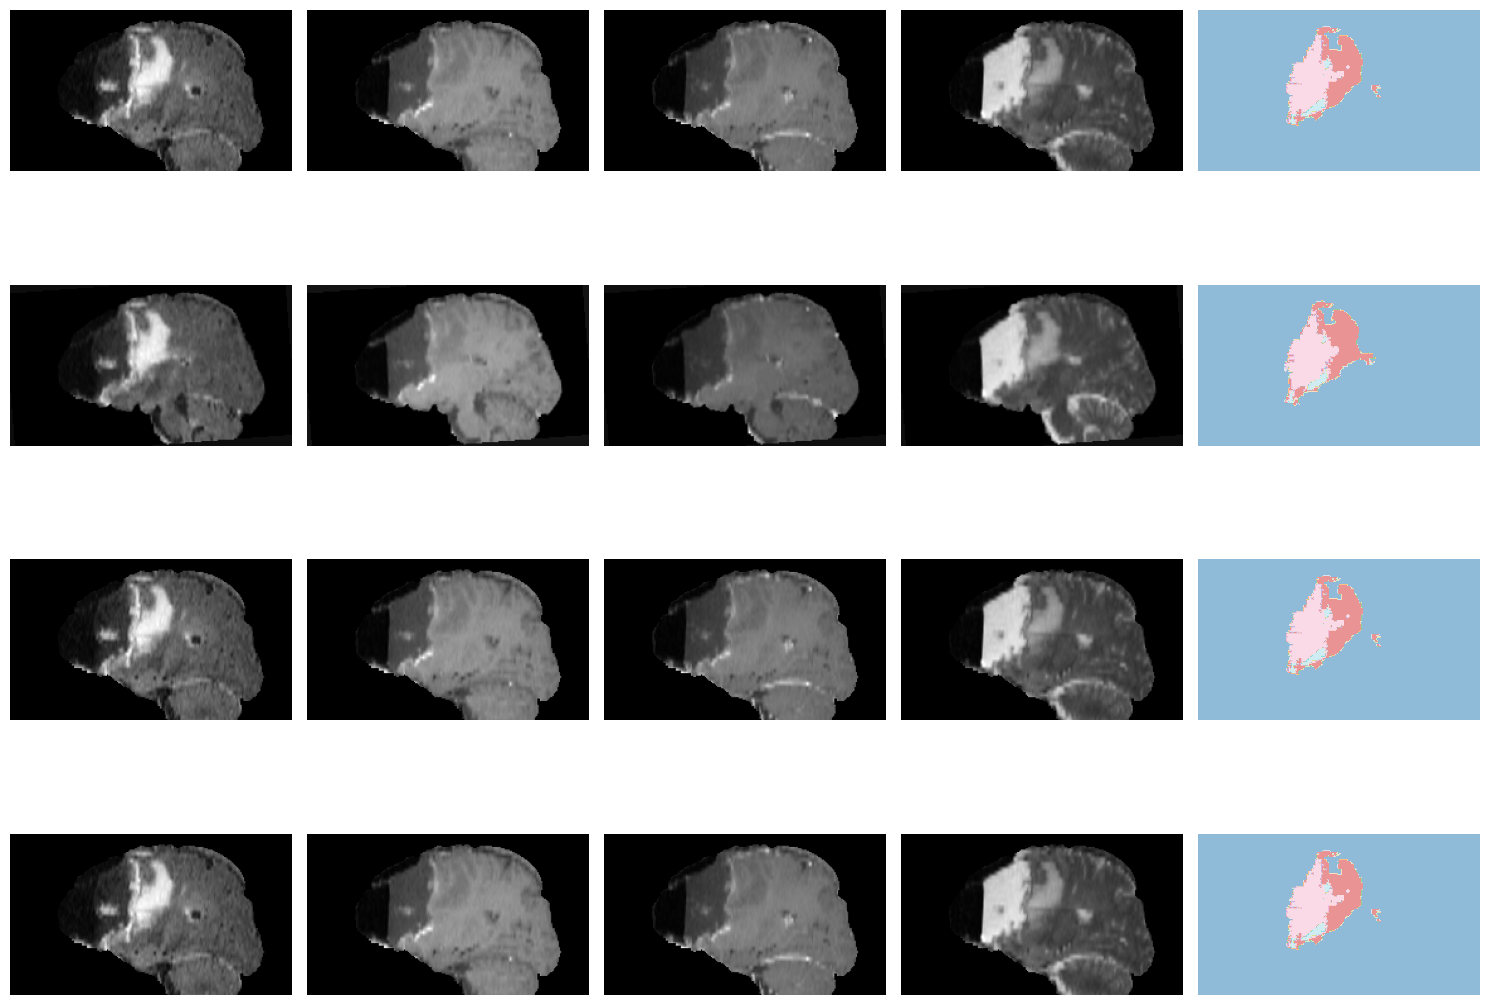

In [34]:
dls.show_batch(anatomical_plane=0, unique=True)

Here's a batch of data:

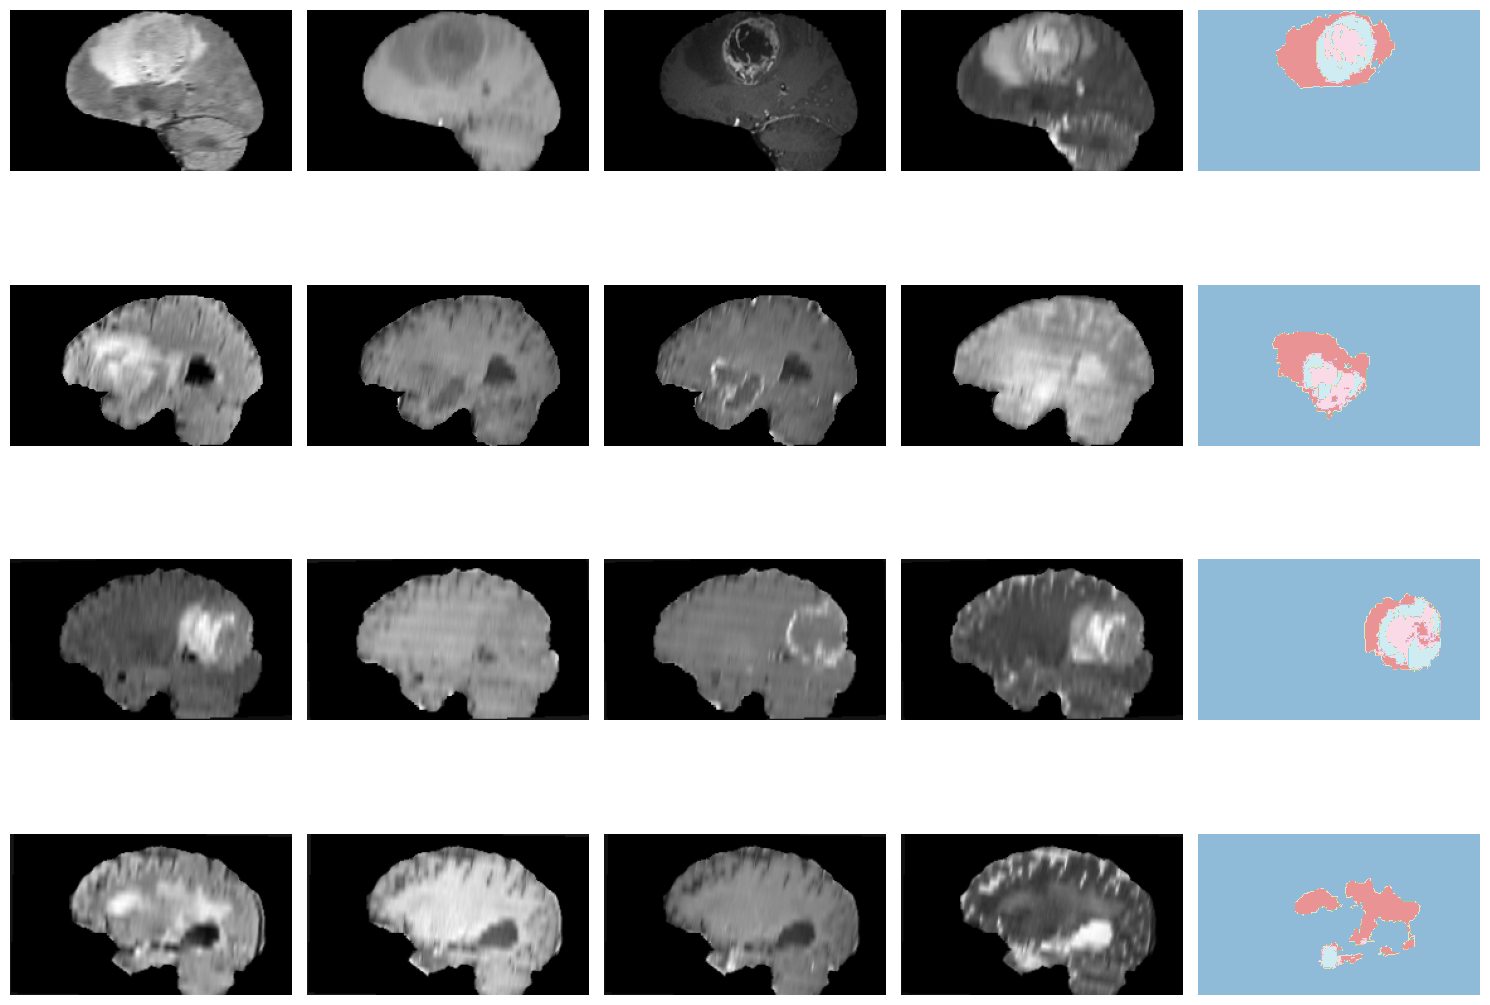

In [35]:
dls.show_batch(anatomical_plane=0) 

# Create and train a model for 3D image data

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, we import an enhanced version of 3D UNet from MONAI. 

## Model architecture

We use an enhanced version of UNet from MONAI. 

Here's an illustration of the basic UNet architecture on which our model is built:

<img src="./assets/unet.jpeg">

In [36]:
from monai.networks.nets import UNet

The code in this cell is importing the `UNet` class from the `monai.networks.nets` module. 

The `UNet` class is a specific implementation of the U-Net architecture, which is commonly used for image segmentation tasks in the field of medical imaging. The U-Net architecture consists of an encoder path and a decoder path, which allows for capturing both high-level and low-level features in the input image.

By importing the `UNet` class, the code is making this class available for use in the current file. It suggests that the U-Net architecture will be used or referenced in the subsequent code.

## Loss function

The Dice coeffiecient measures the degree of overlap between the predicted tumor mask and the "ground truth" masks:

<img width=20% src="./assets/dice.png">

Alterntively, _dice loss_ this can be written: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

We use a loss function that combines Dice loss and Cross Entropy loss and returns the weighted sum of these two losses. 

In [37]:
from monai.losses import DiceCELoss

Check collection of unique labels and their cardinality:

In [46]:
codes = np.unique(med_img_reader(train_df.label.tolist()[0]))
n_classes = len(codes)
codes, n_classes

(array([0., 1., 2., 3.], dtype=float32), 4)

In the first line, `codes` is assigned the result of applying the `np.unique()` function to the `train_df.label.tolist()[0]` expression. This expression retrieves the labels from the `train_df` DataFrame and converts them into a list. The `np.unique()` function then returns the unique elements from that list. The `codes` variable will contain an array of unique labels.

In the second line, `n_classes` is assigned the length of the `codes` array. This will give the number of unique classes or labels present in the `train_df.label.tolist()[0]` data.

Finally, in the third line, the `codes` array and `n_classes` value are printed as a tuple using the `print()` function. This will display the unique labels and the number of classes in the output.

In [47]:
model = UNet(
    spatial_dims=3, 
    in_channels=4, 
    out_channels=n_classes, 
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2), 
    num_res_units=2)

model = model.model

This code consists of two lines of code.

In the first line, a `UNet` model is instantiated and assigned to the variable `model`. The `UNet` class is being used to create a U-Net architecture for image segmentation tasks. The parameters passed to the `UNet` constructor are as follows:
- `spatial_dims=3`: This parameter specifies that the input data has three spatial dimensions, indicating that it is a 3D image.
- `in_channels=4`: This parameter specifies that the input data has four channels. Each channel may represent a different image modality or feature.
- `out_channels=n_classes`: This parameter specifies the number of output channels of the model, which is determined by the `n_classes` variable. `n_classes` represents the number of classes or labels in the segmentation task.
- `channels=(16, 32, 64, 128, 256)`: This parameter specifies the number of channels in each layer of the model. The values `(16, 32, 64, 128, 256)` indicate that the model has five layers, and the number of channels increases progressively from 16 to 256.
- `strides=(2, 2, 2, 2)`: This parameter specifies the stride values used for downsampling the feature maps in each layer. The values `(2, 2, 2, 2)` suggest that the spatial dimensions are halved in each layer.
- `num_res_units=2`: This parameter specifies the number of residual units in each layer of the model. Residual units are commonly used to improve the flow of gradients during training and enhance the model's representational capacity.

In the second line, the `model` attribute of the `model` object is assigned back to the `model` variable. This step is done to access the underlying neural network model for further operations or modifications.

In [48]:
# More details about the model (uncomment):
#model

In the given code excerpt, `model` refers to a variable or object that represents a machine learning model. The specific details of the model are not visible in the provided code snippet, as the line is commented out.

The purpose of the commented line `model` is to provide more details about the model. By uncommenting the line, the details of the model will be displayed, which can include information such as the architecture, parameters, layers, and other relevant properties of the model.

Uncommenting the line `model` allows you to inspect and understand the structure and specifications of the model being used in the code. It can be helpful for debugging, understanding the model's configuration, or gaining insights into its architecture and parameters.

In [44]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

The code in this cell assigns a value to the variable `loss_func`. It creates an instance of the `CustomLoss` class and initializes it with a specific loss function called `DiceCELoss`. 

The `DiceCELoss` is a combination of two loss functions: Dice Loss and Cross-Entropy Loss. It is commonly used for image segmentation tasks. 

The `CustomLoss` class is likely a custom implementation or wrapper around the `DiceCELoss` function, providing additional functionality or customization options. 

In this specific instantiation, the `DiceCELoss` is configured with the following parameters:
- `to_onehot_y=True`: This parameter indicates that the target labels should be converted to one-hot encoded format. One-hot encoding represents each class as a binary vector, where each element corresponds to a class and is either 0 or 1.
- `include_background=True`: This parameter specifies whether to include the background class in the loss calculation. The background class represents the regions of the image that do not belong to any specific class.
- `softmax=True`: This parameter indicates that the output of the model should be passed through a softmax activation function before calculating the loss. Softmax function normalizes the output values to represent class probabilities.

By using this `loss_func` in the training process, the model will be optimized based on the combination of Dice Loss and Cross-Entropy Loss, with the specified configurations for one-hot encoding, background inclusion, and softmax activation.

## Train the model

Now we're ready to train the model. After training, we'll have something that can produce the following results on new, unseen MR recordings:

<img width=60% src="./assets/prediction_results.png">

<img src="./assets/pred_093.gif">

> We use a built-in ranger optimizer from fastai, that combines (RAdam + Lookahead) into a single optimizer. 
<i>Ranger21 tested with fastai available:</i> https://github.com/lessw2020/Ranger21

In [39]:
%%time
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)#.to_fp16()

In the given code excerpt, `Learner` refers to a class or object that is being instantiated. It is likely a part of a machine learning framework or library, such as fastai or MONAI.

A `Learner` is typically responsible for managing the training process of a machine learning model. It encapsulates various components and functionalities required for training, such as the model architecture, data loaders, loss function, optimizer, and evaluation metrics.

In this specific code snippet, a `Learner` object is being created with the following parameters:

- `dls`: It represents the data loaders, which are responsible for loading and preprocessing the training and validation data.
- `model`: It represents the machine learning model that will be trained.
- `loss_func`: It specifies the loss function that will be used to measure the discrepancy between the predicted outputs and the actual targets during training.
- `opt_func`: It specifies the optimizer function that will be used to update the model's parameters based on the computed gradients.
- `metrics`: It specifies the evaluation metric(s) that will be used to assess the performance of the model during training.

The `Learner` object is then assigned to the variable `learn`, which can be used to perform various training-related operations, such as training the model, making predictions, and evaluating the model's performance.

In [40]:
learn.summary()

UNet (Input shape: 4 x 4 x 224 x 224 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 112 x 112  
Conv3d                                    1744       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    1744       True      
____________________________________________________________________________
                     4 x 32 x 56 x 56 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
Dropout                    

We might want to use the model and the dataset to find a reasonable learning rate value automatically. For this, we can use the learning rate finder from fastai.

CPU times: user 1min 2s, sys: 13.8 s, total: 1min 16s
Wall time: 2min 16s


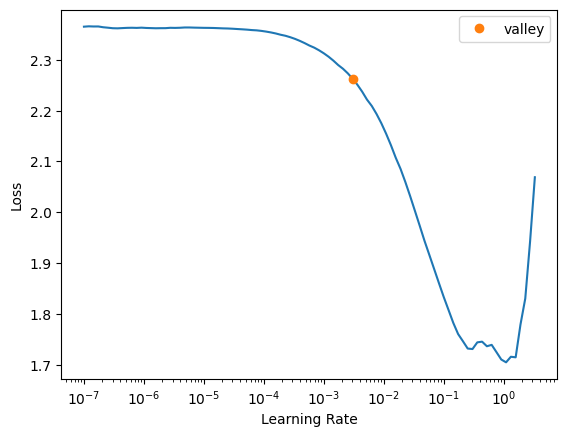

In [41]:
%%time
if not (colab or kaggle):
    lr = learn.lr_find()
else:
    lr = 8e-4

In the interest of time, our model is trained for only a few epochs. If you have the time, you can raise this number to something higher (f.ex. `epochs=30` or more) to get a model that performs much better.

In [42]:
epochs = 1

> As shown in https://walkwithfastai.com/Segmentation, with the ranger optimizer, we want to use a different fit function, called `fit_flat_cos`, i.e. fit self.model for `n_epoch` at flat `lr` before a cosine annealing.

In [43]:
%%time
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.394358,1.024705,"tensor([0.2981, 0.0117, 0.0120])",01:37


<function compute_meandice at 0x7fc77debd670>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.


CPU times: user 46.6 s, sys: 11.1 s, total: 57.7 s
Wall time: 1min 37s


In [53]:
if (colab or kaggle):
    !wget https://www.dropbox.com/s/tmebx1m4q57tn7b/trained.braintumor-model.pth?dl=1
    !mkdir models
    !mv trained.braintumor-model.pth?dl=1 models/trained.braintumor-model.pth

In [54]:
#!wget https://www.dropbox.com/s/tmebx1m4q57tn7b/trained.braintumor-model.pth?dl=1

In [50]:
!ls -al

total 78132
drwxrwxr-x  6 arvid arvid     4096 jan.   5 12:10  .
drwxrwxr-x 10 arvid arvid     4096 jan.   5 00:38  ..
drwxrwxr-x  2 arvid arvid     4096 jan.   5 02:20  assets
drwxrwxr-x  4 arvid arvid     4096 jan.   5 11:42  data
-rw-rw-r--  1 arvid arvid  2910791 jan.   5 12:10  ELMED219-Lab1-BRATS-3D-fastMONAI-extended.ipynb
drwxrwxr-x  2 arvid arvid     4096 jan.   5 11:06  .ipynb_checkpoints
drwxrwxr-x  2 arvid arvid     4096 jan.   5 12:08  models
-rw-rw-r--  1 arvid arvid     3010 jan.   5 02:34  README.md
-rw-rw-r--  1 arvid arvid 77063625 jan.   5 12:11 'trained.braintumor-model.pth?dl=1'


In [51]:
#!mv trained.braintumor-model.pth?dl=1 models/trained.braintumor-model-Oct2022.pth

In [52]:
learn.load('trained.braintumor-model-Oct2022')

In [55]:
#learn.save('trained.braintumor-model-n_epoch_1')
#learn.export('./models/trained.braintumor-model-Oct2022.pkl')

In [56]:
#store_variables(pkl_fn='./models/vars-Oct2022.pkl', var_vals=[reorder, resample])

In [57]:
#learn.summary()

# Evaluate results

Let's check how the model performs on some validation data:

<function compute_meandice at 0x7fc77debd670>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.


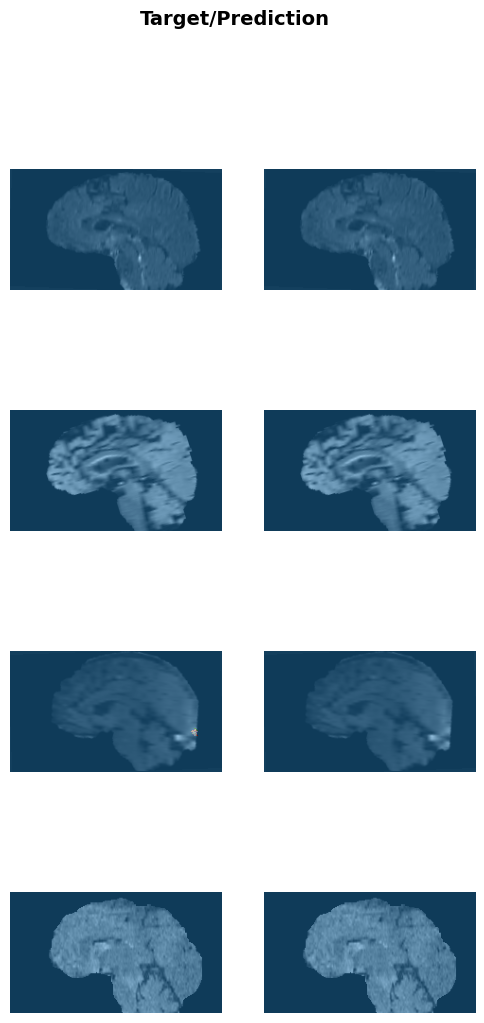

In [58]:
learn.show_results(anatomical_plane=0, ds_idx=0)

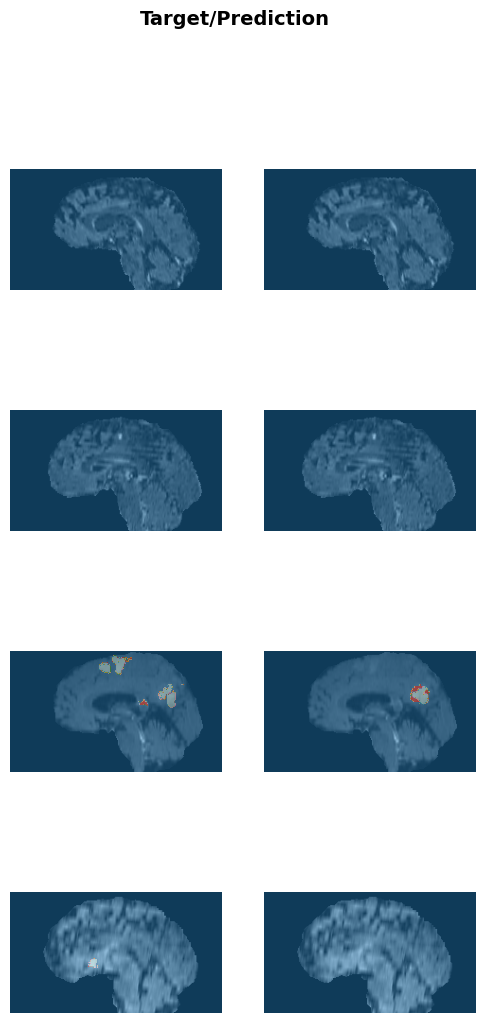

In [59]:
learn.show_results(anatomical_plane=0, ds_idx=1)

## Inference on test data

Remember that we also have some unseen test data that we can try our model on:

In [60]:
test_dl = learn.dls.test_dl(test_df[:10],with_labels=True)

Here are some examples from out test set:

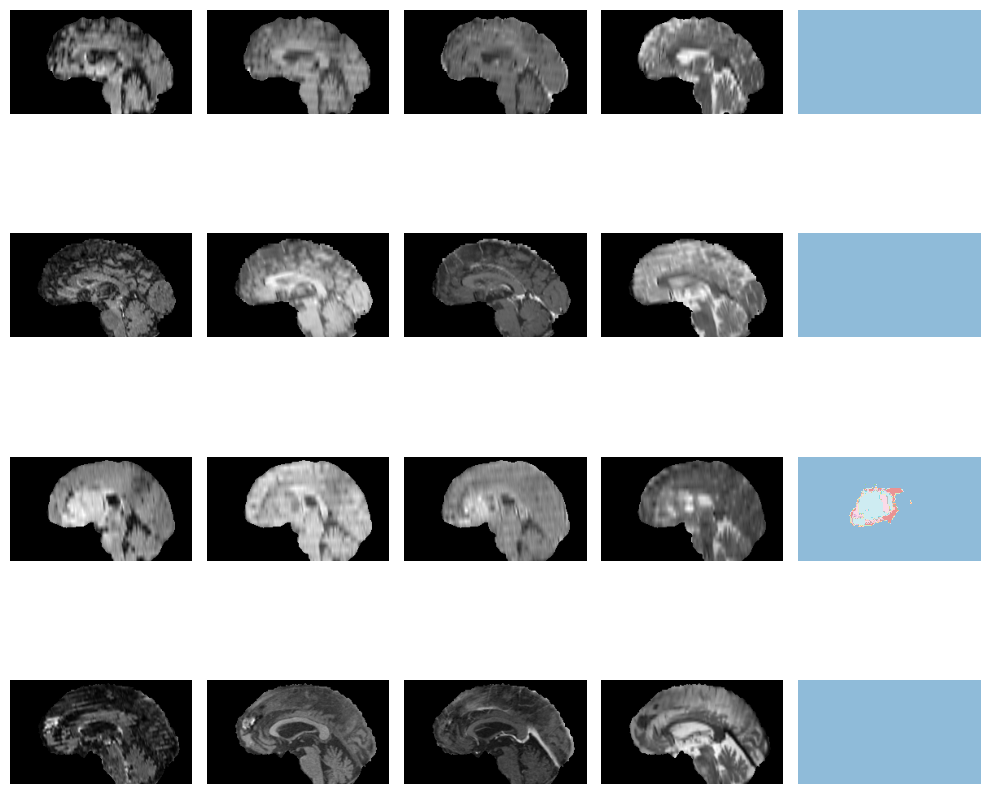

In [61]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

Let's run the test set through our trained model:

In [62]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([10, 4, 224, 224, 128]), torch.Size([10, 1, 224, 224, 128]))

We can score the model using the Dice coefficient for the labels 1,2 and 3: 

( n_epoch = 1 results in very poor perfomance on unseen data: `tensor([0.2108, 0.0081, 0.0040])` )

The model trained with x epochs for the Oct2022 seminar, gives:

In [63]:
multi_dice_score(pred_acts, labels)

tensor([0.7252, 0.5850, 0.7106])

Here are some of the results for inspection:

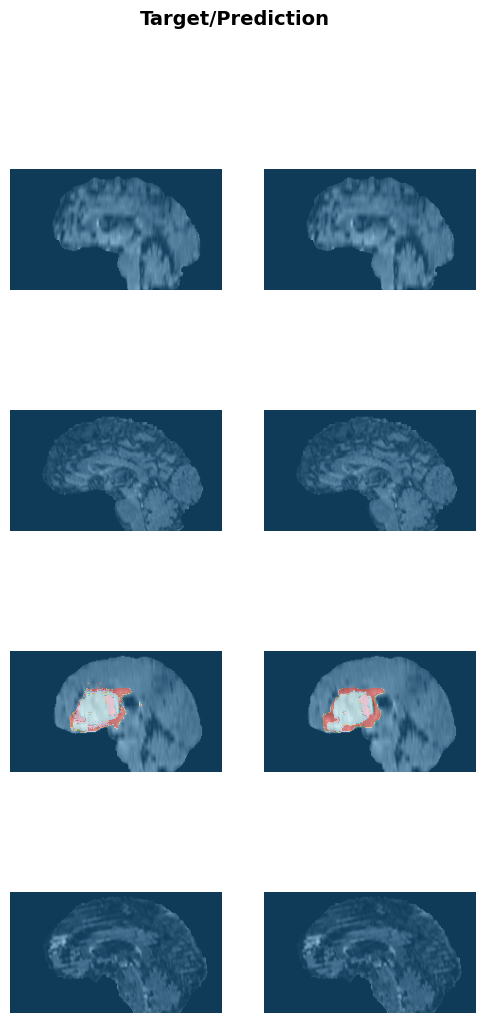

In [64]:
learn.show_results(anatomical_plane=0, dl=test_dl)

### Save segmentation results as Nifti  (.nii.gz) files

In [65]:
import os

save_path = Path('./data/results/braintumor')
#path.mkdir(parents=True, exist_ok=True)
if not os.path.exists(save_path):
    os.makedirs(save_path)


In [66]:
training_imgs = [data['image'] for data in training_data.data]
training_imgs[:10]

['data/Task01_BrainTumour/imagesTr/BRATS_442.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_389.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_380.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_245.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_453.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_252.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_078.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_427.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_421.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_440.nii.gz']

In [67]:
test_data = DecathlonDataset(root_dir=path, task="Task01_BrainTumour", section="testing", download=True,
                                 cache_num=0, num_workers=8)

2023-01-05 12:18:15,880 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-01-05 12:18:15,881 - INFO - File exists: data/Task01_BrainTumour.tar, skipped downloading.
2023-01-05 12:18:15,881 - INFO - Non-empty folder exists in data/Task01_BrainTumour, skipped extracting.


In [68]:
test_imgs = [data['image'] for data in test_data.data]
test_imgs[:10]

['data/Task01_BrainTumour/imagesTs/BRATS_634.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_498.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_539.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_573.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_491.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_554.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_689.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_532.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_688.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_627.nii.gz']

In [69]:
# learn_inf = load_learner('braintumor_model.pkl', cpu=False);
learn_inf = load_learner('./models/trained.braintumor-model-Oct2022.pkl', cpu=False);

In [70]:
reorder, resample = load_variables(pkl_fn='./models/vars-Oct2022.pkl')
reorder, resample

(False, [1.0, 1.0, 1.0])

In [71]:
idx = 0
fn = test_imgs[idx]

In [72]:
%%time
mask = inference(learn_inf, reorder, resample, fn, save_path=save_path)

CPU times: user 5.63 s, sys: 729 ms, total: 6.36 s
Wall time: 1.21 s


In [73]:
print(mask.path)
print(f"{save_path}/pred_{Path(fn).name}")

data/Task01_BrainTumour/imagesTs/BRATS_634.nii.gz
data/results/braintumor/pred_BRATS_634.nii.gz


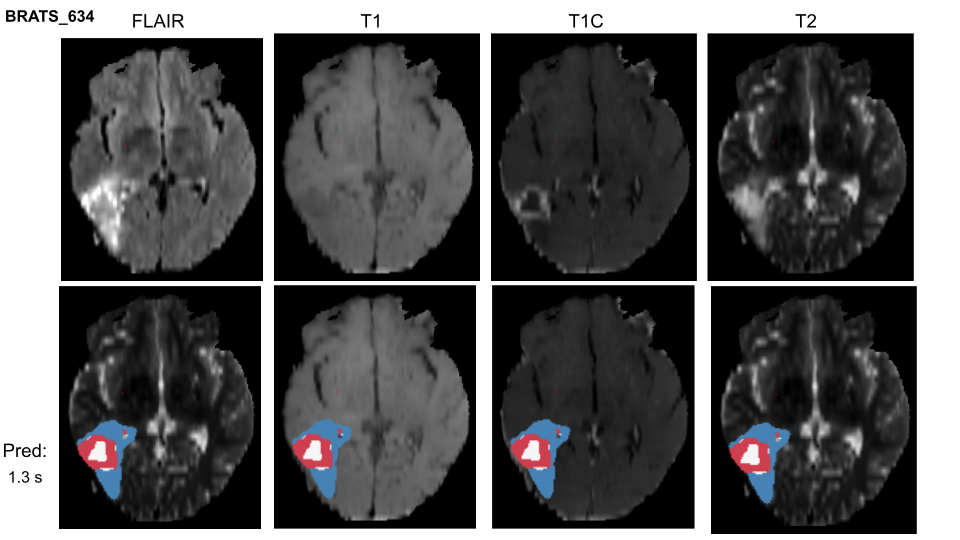

In [74]:
from IPython.display import Image
Image(filename="./assets/pred_BRATS_634.png")

# Export the model and dataloader

The final step is to export the model and the pre-processing steps so that they can be used in some further context:

In [128]:
#store_variables(pkl_fn='./models/vars_n_epoch_1.pkl', var_vals=[reorder, resample])

In [107]:
#learn.export('braintumor_model_n_epoch_1.pkl')

This model can then, in principle, be taken further into an infrastructure where it can be tested against new data. 

# Extra material: Radiomics

Once we've segmented tumors into meaningful subcompartments, we have a set of regions of interest (ROIs) and can start asking many interesting questions. Computing the tumor volumes is an obvious idea. We can also try to compute various shape characteristics. Perhaps the intensity variation in the tumor is a valuable indicator of tumor hetereogeneity. What about the tumor location? 

Extracting features from objects of interest in medical images for diagnostic purposes is often referred to as **radiomics**. The goal of radiomics is to extract information from medical images that can be used as part of a medical imaging-based diagnostic workflow. The information can be extracted from various imaging modalities, e.g., different MRI contrasts, PET imaging, CT imaging, etc. One can then combine it with other sources of information (e.g., demographics, clinical data, genetics). In such a way, radiomics–and radiogenomics–can open the door to sophisticated and powerful analyses.

**Radiomics workflow:**

<img src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/radiomics.png">

If you're interested, you can have a look at a basic radiomics approach here: https://github.com/MMIV-ML/presimal2022.